# Prepare disconnection of "sources of many high dimensional simplices"

We want to select cells that are "sources of many high dimensional simplices" and are highly reliable in order to disconnect their outputs and check if this decreases their reliability

ℹ️ Related ticket: [[ACCS-19](https://bbpteam.epfl.ch/project/issues/browse/ACCS-19)]

In [105]:
import hashlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import os
from bluepy import Circuit

## Part 1: Select fixed set of neurons to disconnect outputs from [OLD]

In [2]:
# Load pre-selected source neurons of high-dim simplices
#  Keys corresponding to simplex dimension: 4, 5, 6
nrn_file = '/gpfs/bbp.cscs.ch/project/proj102/egas/reliability/sources_of_many_high_dim_simplices.pkl'
dim_keys = [4, 5, 6]

with open(nrn_file, 'rb') as f:
    nrn_high_dim_src = pickle.load(f)

In [3]:
# Load pre-computed reliabilities
reliab_file = '/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/BlobStimReliability_O1v5-SONATA/reliability/reliability_exc_sigma10ms.npz'
reliab_exc = np.load(reliab_file)['reliab_centered']
gids_exc = np.load(reliab_file)['gids']

In [4]:
# Load reliabilities for pre-selected source neurons
reliab_high_dim_src = {}
for k in dim_keys:
    reliab_sel = []
    for gid in nrn_high_dim_src[k]:
        gid_sel = np.where(gids_exc == gid)[0]
        if len(gid_sel) == 0:
            reliab_sel.append(np.nan)
        else:
            reliab_sel.append(reliab_exc[gid_sel[0]])
    reliab_high_dim_src[k] = np.array(reliab_sel)

print('Reliabilities:')
for k in dim_keys:
    print(f'{k}: {np.sum(np.isfinite(reliab_high_dim_src[k]))} of {len(reliab_high_dim_src[k])} values, min={np.nanmin(reliab_high_dim_src[k]):.3f}, max={np.nanmax(reliab_high_dim_src[k]):.3f}, mean={np.nanmean(reliab_high_dim_src[k]):.3f}')

Reliabilities:
4: 99 of 100 values, min=-0.000, max=0.658, mean=0.251
5: 100 of 100 values, min=-0.000, max=0.658, mean=0.216
6: 96 of 100 values, min=-0.000, max=0.677, mean=0.240


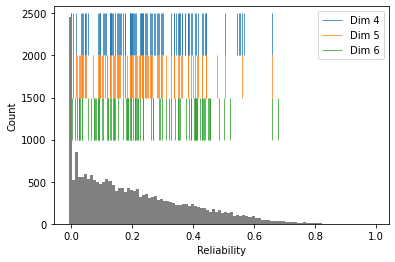

In [5]:
# Plot all reliabilities
plt.figure()
plt.hist(reliab_exc, bins=100, color='grey')
plt.ylim(plt.ylim())
for k, c, y in zip(dim_keys, ['tab:blue', 'tab:orange', 'tab:green'], np.linspace(2000, 1000, 3)):
    plt.vlines(reliab_high_dim_src[k], ymin=y, ymax=y + 500, color=c, alpha=0.75, lw=1, zorder=0, label=f'Dim {k}')
# plt.grid()
plt.xlabel('Reliability')
plt.ylabel('Count')
plt.legend()
plt.show()

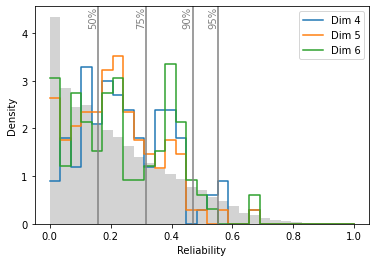

In [6]:
# Plot reliability histograms
bins = np.linspace(0, 1, 30)
plt.figure()
plt.hist(reliab_exc, bins=bins, density=True, color='lightgrey')
for k in dim_keys:
    hist_dens = np.histogram(reliab_high_dim_src[k], bins=bins, density=True)[0]
    plt.step(bins, np.hstack([hist_dens[0], hist_dens]), label=f'Dim {k}')
for prc in [50, 75, 90, 95]:
    plt.axvline(np.percentile(reliab_exc, prc), color='grey')
    plt.text(np.percentile(reliab_exc, prc), np.max(plt.ylim()), f'{prc}%', rotation=90, color='grey', ha='right', va='top')
plt.xlabel('Reliability')
plt.ylabel('Density')
plt.legend()
plt.show()

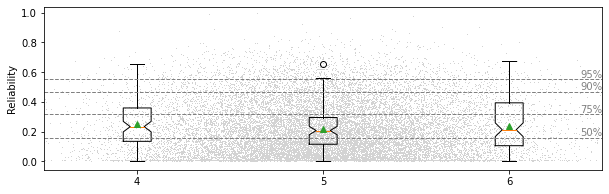

In [7]:
# Plot selected reliabilities
np.random.seed(0)
plt.figure(figsize=(10, 3))
plt.plot(np.random.randn(len(reliab_exc)) * 0.5 + np.mean(dim_keys), reliab_exc, ',', color='lightgrey')
for idx, k in enumerate(dim_keys):
    plt.boxplot(reliab_high_dim_src[k][np.isfinite(reliab_high_dim_src[k])], positions=[k], showmeans=True, notch=True)
plt.xticks(dim_keys)
plt.xlim([min(dim_keys) - 0.5, max(dim_keys) + 0.5])

for pct in [50, 75, 90, 95]:
    plt.plot(plt.xlim(), np.full(2, np.percentile(reliab_exc, pct)), '--', color='grey', linewidth=1)
    plt.text(max(plt.xlim()), np.percentile(reliab_exc, pct), f'{pct}%', color='grey', ha='right', va='bottom')
# plt.grid()
plt.ylabel('Reliability')
plt.show()

Select top-dim GIDs with high reliability

In [9]:
# Create table with GIDs above given reliability percentile
prc_list = np.arange(50, 96, 5)
print('Reliability percentiles:')
for prc in prc_list:
    print(f'{prc}%: {np.percentile(reliab_exc, prc):.2f}')

gid_table = {}
for kidx, k in enumerate(dim_keys):
    gid_table[k] = []
    for pidx, prc in enumerate(prc_list):
        gid_table[k].append(list(nrn_high_dim_src[k][reliab_high_dim_src[k] > np.percentile(reliab_exc, prc)]))
gid_table = pd.DataFrame.from_dict(gid_table, orient='index', columns=prc_list)
gid_table

Reliability percentiles:
50%: 0.16
55%: 0.19
60%: 0.21
65%: 0.24
70%: 0.28
75%: 0.32
80%: 0.36
85%: 0.41
90%: 0.47
95%: 0.55


,50,55,60,65,70,75,80,85,90,95
4,"[81724, 89391, 89373, 91372, 91628, 88146, 923...","[81724, 89391, 89373, 91372, 91628, 88146, 923...","[81724, 89391, 89373, 91372, 91628, 88146, 923...","[81724, 89391, 89373, 91372, 91628, 88146, 923...","[81724, 89391, 89373, 91372, 91628, 88146, 923...","[81724, 89391, 89373, 91372, 91628, 88146, 923...","[81724, 89373, 91372, 91628, 88146, 92301, 896...","[89373, 91628, 88146, 92301, 67997, 93645, 815...","[91628, 88146, 92301, 75894, 74042, 73919, 79868]","[91628, 92301, 75894]"
5,"[81724, 89391, 91628, 82979, 88146, 89373, 923...","[81724, 89391, 91628, 82979, 88146, 89373, 923...","[81724, 89391, 91628, 88146, 89373, 92301, 913...","[81724, 89391, 91628, 88146, 89373, 92301, 913...","[81724, 89391, 91628, 88146, 89373, 92301, 913...","[81724, 89391, 91628, 88146, 89373, 92301, 913...","[81724, 91628, 88146, 89373, 92301, 91372, 818...","[91628, 88146, 89373, 92301, 81862, 88869, 936...","[91628, 88146, 92301, 88869]","[91628, 92301]"
6,"[92907, 88807, 89391, 81724, 75456, 75960, 815...","[92907, 88807, 89391, 81724, 75456, 75960, 878...","[92907, 89391, 81724, 75456, 75960, 87894, 903...","[89391, 81724, 75456, 87089, 90174, 75416, 773...","[89391, 81724, 75456, 87089, 90174, 75416, 830...","[89391, 81724, 75456, 87089, 90174, 75416, 911...","[81724, 90174, 75416, 91149, 92301, 74934, 754...","[90174, 92301, 74934, 75489, 75880, 76032, 818...","[92301, 75880, 91150, 78761, 80932]","[92301, 80932]"


In [10]:
# Create table with GID counts above given reliability percentile
count_table = np.full([len(dim_keys), len(prc_list)], -1)
for pidx, prc in enumerate(prc_list):
    for kidx, k in enumerate(dim_keys):
        count_table[kidx, pidx] = len(gid_table.loc[k, prc])
count_table = pd.DataFrame(count_table, columns=prc_list, index=dim_keys)
count_table

,50,55,60,65,70,75,80,85,90,95
4,68,64,54,46,39,33,25,14,7,3
5,62,58,48,37,30,23,17,10,4,2
6,61,55,48,41,38,34,27,19,5,2


In [11]:
# Unique GID + counts (all dims)
gids_prc = {}
for prc in prc_list:
    gids_prc[prc] = np.unique(np.concatenate(list(gid_table[prc])),return_counts=True)
[len(gids_prc[prc][0]) for prc in prc_list]

[135, 125, 107, 89, 77, 66, 51, 32, 12, 4]

In [16]:
# Unique GID + counts (dims 5, 6)
gids_prc = {}
for prc in prc_list:
    gids_prc[prc] = np.unique(np.concatenate(list(gid_table[prc].loc[[5, 6]])), return_counts=True)
[len(gids_prc[prc][0]) for prc in prc_list]

[112, 103, 88, 72, 62, 52, 40, 27, 8, 3]

In [138]:
# # ***SELECTION 1: 10 cells***
# # Selecting 8 dim 5/6 GIDs with relibailities above 90-percentile + 2 random ones from dim 4
# np.random.seed(1234)
# gids_sel56 = gids_prc[90][0]
# gids_sel4 = np.random.choice(np.setdiff1d(gid_table[90].loc[4], gids_prc[90][0]), 2, replace=False)
# gids_sel = list(np.unique(np.hstack([gids_sel56, gids_sel4])))

# print(f'{len(gids_sel)} selected top-dim GIDs with high reliability:')
# print(gids_sel)


10 selected top-dim GIDs with high reliability:
[73919, 74042, 75880, 78761, 80932, 88146, 88869, 91150, 91628, 92301]


In [212]:
# # Print reliabilities of selected cells
# reliab_sel = reliab_exc[[np.where(gids_exc == gid)[0][0] for gid in gids_sel]]
# print('Reliabilities of selected GIDs:')
# print([f'{r:.2f}' for r in reliab_sel])

Reliabilities of selected GIDs:
['0.55', '0.54', '0.48', '0.50', '0.68', '0.50', '0.48', '0.52', '0.56', '0.66']


In [17]:
# ***SELECTION 2: ~100 cells***
# Selecting all dim 5/6 GIDs with relibailities above 50-percentile
gids_sel = list(gids_prc[50][0])

print(f'{len(gids_sel)} selected top-dim GIDs with high reliability:')
print(gids_sel)


112 selected top-dim GIDs with high reliability:
[66565, 67581, 67997, 70310, 71832, 73031, 73540, 74934, 75084, 75391, 75416, 75456, 75489, 75806, 75880, 75960, 76032, 76470, 77358, 77424, 77522, 77524, 78008, 78304, 78395, 78695, 78761, 79830, 79842, 79854, 80514, 80528, 80554, 80630, 80932, 81413, 81552, 81580, 81724, 81862, 82096, 82107, 82127, 82337, 82377, 82725, 82866, 82979, 83013, 83134, 83137, 83175, 83271, 83866, 84004, 84241, 84311, 84375, 84520, 84777, 84922, 84936, 85326, 85387, 85535, 86143, 87089, 87437, 87605, 87894, 87926, 88046, 88146, 88663, 88696, 88807, 88869, 89010, 89016, 89173, 89311, 89373, 89391, 89603, 89626, 89881, 90040, 90133, 90174, 90368, 90505, 90548, 90622, 90986, 91149, 91150, 91372, 91498, 91628, 91759, 91886, 92019, 92301, 92361, 92363, 92653, 92896, 92907, 93180, 93314, 93645, 93857]


In [21]:
# Print reliabilities of selected cells
reliab_sel = reliab_exc[[np.where(gids_exc == gid)[0][0] for gid in gids_sel]]
print('Reliabilities of selected GIDs:')
print([f'{r:.2f}' for r in reliab_sel])
print(f'MIN={np.min(reliab_sel):.2f}; MAX={np.max(reliab_sel):.2f}; MEAN={np.mean(reliab_sel):.2f}')

Reliabilities of selected GIDs:
['0.28', '0.29', '0.41', '0.27', '0.45', '0.32', '0.36', '0.41', '0.18', '0.45', '0.41', '0.35', '0.44', '0.40', '0.48', '0.23', '0.45', '0.41', '0.26', '0.30', '0.21', '0.39', '0.43', '0.45', '0.41', '0.19', '0.50', '0.21', '0.33', '0.19', '0.43', '0.38', '0.41', '0.18', '0.68', '0.19', '0.18', '0.43', '0.41', '0.43', '0.34', '0.27', '0.22', '0.33', '0.21', '0.23', '0.20', '0.19', '0.29', '0.21', '0.41', '0.23', '0.26', '0.30', '0.29', '0.22', '0.36', '0.19', '0.24', '0.20', '0.28', '0.29', '0.41', '0.26', '0.24', '0.18', '0.35', '0.19', '0.26', '0.22', '0.22', '0.20', '0.50', '0.17', '0.21', '0.21', '0.48', '0.40', '0.21', '0.20', '0.35', '0.44', '0.35', '0.31', '0.38', '0.25', '0.27', '0.25', '0.42', '0.22', '0.22', '0.20', '0.43', '0.25', '0.39', '0.52', '0.38', '0.23', '0.56', '0.34', '0.29', '0.36', '0.66', '0.34', '0.17', '0.38', '0.18', '0.23', '0.24', '0.20', '0.44', '0.34']
MIN=0.17; MAX=0.68; MEAN=0.32


Prepare cell target file for simulations

In [22]:
# Prepare & write target file (using hashed target name, to avoid confusion in case of different selections)
hash_obj = hashlib.shake_128()
hash_obj.update(str(gids_sel).encode('UTF-8'))
hash_code = hash_obj.hexdigest(4).upper()

target_file = '../workflows/top_dim_high_reliab_cells.target'
target_name = 'TopDimHighReliab_' + hash_code
with open(target_file, 'a') as fid:
    gids_str = ' '.join([f'a{gid}' for gid in gids_sel])
    target_str = f'Target Cell {target_name}\n{{\n{gids_str}\n}}\n'
    fid.write(target_str)
print(f'Cell target "{target_name}" with {len(gids_sel)} cells written to {target_file}')

Cell target "TopDimHighReliab_F97E29B9" with 112 cells written to ../workflows/top_dim_high_reliab_cells.target


## Part 2: Select neurons to disconnect outputs from based on randomized "block design"

### Prepare "Regular uniform block design", to set up simulation campaigns

In [2]:
# Path for setting up simulation campaign
save_path = '/gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/block_design'

In [3]:
r = 30 # Total number of sims a given cell is manipulated (=sum of columns)
k = 10 # Number of manipulated cells at a time, i.e., within one simulation (=sum of rows)
v = 30 # Total number of manipulated cells

b = v * r / k # Total number of sims
assert b == int(b), 'ERROR: Total number of sims not integer number!'
b = int(b)
print(f'Total number of simulations in block design: {b}')

Total number of simulations in block design: 90


In [4]:
def check_sums(mat, row_sum, col_sum):
    return np.all(np.sum(mat, 0) == row_sum) and np.all(np.sum(mat, 1) == col_sum)

In [5]:
# Generate simple block table
def generate_block_table(r, k, v, b):
    assert b == v * r / k, 'ERROR: Parameter mismatch!'
    block_table = np.zeros((v, b), dtype='bool')
    for i in range(np.round(b / r).astype(int)):
        block_table[i * k : (i + 1) * k, i * r : (i + 1) * r] = True
    assert check_sums(block_table, k, r), 'ERROR: Row/colum sum mismatch!'
    return block_table

block_table = generate_block_table(r, k, v, b)


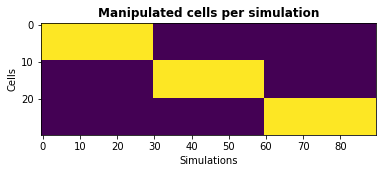

In [6]:
plt.figure()
plt.imshow(block_table)
plt.xlabel('Simulations')
plt.ylabel('Cells')
plt.title('Manipulated cells per simulation', fontweight='bold')
plt.show()

In [7]:
# Generate randomized block table
def generate_random_block_table(r, k, v, b, seed=0):
    block_table = generate_block_table(r, k, v, b)
    np.random.seed(seed)
    for c1 in range(block_table.shape[1]):
        for ik in range(k):
            r1 = np.random.choice(np.where(block_table[:, c1])[0], 1)[0]
            c2 = np.random.choice(np.where(~block_table[r1, :])[0], 1)[0]
            r2 = np.random.choice(np.where(np.logical_and(block_table[:, c2], ~block_table[:, c1]))[0], 1)[0]
            block_table[r1, c1] = False
            block_table[r2, c1] = True
            block_table[r1, c2] = True
            block_table[r2, c2] = False
            assert check_sums(block_table, k, r), 'ERROR: Row/colum sum mismatch!'
    return block_table

block_table = generate_random_block_table(r, k, v, b, seed=10)

In [8]:
# Save block table [using hashed name, to avoid confusion in case different seeds/algorithms were used to generate table]
bin_table = '\n'.join([''.join(b.astype(str)) for b in block_table.astype(int)]) # Binary string matrix to compute hash from (+ saving to .)
print(bin_table[:3 * (b + 1)] + '...' + bin_table[-3 * (b + 1):] + '\n')

hash_obj = hashlib.shake_128()
hash_obj.update(bin_table.encode('UTF-8'))
hash_code = hash_obj.hexdigest(4).upper()

block_file = os.path.join(save_path, f'block_table_{k}-{v}_{r}-{b}_{hash_code}')
np.save(block_file + '.npy', block_table)

with open(block_file + '.txt', 'w') as f:
    f.write(bin_table)

print(f'Block table written to "{block_file}.npy/.txt"')

011101010000000110000101110000001100101001100000010000010001000011001000110001001000110100
000001000000111101000000111001001001001000010001101010000000101000011000110101000110000101
000000111011001010111000010000010000011001100100001101101100000001010000000010100010001010
...
011000000110010010111000010010010001010100001000000101000001001110110001011011000000010000
000010000001110010100110101000100010010000001101010010101100010000101100101101000000000100
000011001010110101000010010100001100100110011010000000000001000001110110001000000001111000

Block table written to "/gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/block_design/block_table_10-30_30-90_0C8285E1.npy/.txt"


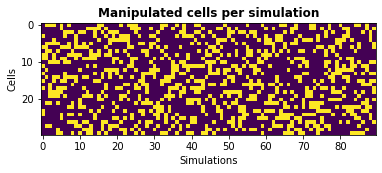

In [9]:
# Plot block table
plt.figure()
plt.imshow(block_table)
plt.xlabel('Simulations')
plt.ylabel('Cells')
plt.title('Manipulated cells per simulation', fontweight='bold')
plt.savefig(block_file + '.png', dpi=300)
plt.show()

ℹ️ Using <code>block_table_10-30_30-90_0C8285E1.npy</code> to set up simulation campaign!

### Select cells to disconnect output from (i) based on structure or (ii) randomly, to set up simulation campaigns

In [10]:
# Load (EXC) adj. matrix [provided by Daniela]
import scipy.sparse as sparse
import pandas as pd
import numpy as np

#Load data
root = "/gpfs/bbp.cscs.ch/project/proj102/egas/TriDy/data/"
adj = sparse.load_npz(root + "connectivity.npz")
nrn_info = pd.read_pickle(root + "neuron_info.pickle")
synapse_class = "EXC"
shift = nrn_info.index[0]
ind = (nrn_info[nrn_info["synapse_class"] == synapse_class].index).to_numpy() - shift
adj_exc = adj[np.ix_(ind,ind)]

In [11]:
# Load list of sources of high-dim simplices [provided by Daniela]
path = '/gpfs/bbp.cscs.ch/project/proj102/egas/reliability/data/source_participation_max_simp_EXC_subnetwork.pkl'
nrn_info = pd.read_pickle(path)

# Lowest number of 6-simplices the cells must be a source of
multiplicity = 4 # 3 # 4
selected_gids = nrn_info[nrn_info['source_participation_dim_6'] >= multiplicity].index.to_numpy()
print(f'{len(selected_gids)} sources of high-dim simplices selected (multiplicity >= {multiplicity})')

36 sources of high-dim simplices selected (multiplicity >= 4)


In [12]:
# Map GIDs to EXC indices related to adj_exc
assert np.all(np.diff(nrn_info.index) > 0), 'ERROR: Wrong nrn_info order of GIDs!'
gids_exc = nrn_info[nrn_info['synapse_class'] == 'EXC'].index
gid_mapping = np.full(max(gids_exc) + 1, -1)
gid_mapping[gids_exc] = np.arange(len(gids_exc))

In [13]:
# Sample total number of v cells to be manipulated
np.random.seed(0)

# (1) Sample randomly from sources of high-dim simplices
gids_manip_struct = np.sort(np.random.choice(selected_gids, size=v, replace=False))

# (2) Sample randomly from all EXC neurons
gids_manip_rnd = np.sort(np.random.choice(gids_exc, size=v, replace=False))
print(f'{np.sum(np.isin(gids_manip_rnd, selected_gids))} randomly selectecd cells part of {len(selected_gids)} sources of high-dim simplices')

0 randomly selectecd cells part of 36 sources of high-dim simplices


In [14]:
# Write to .txt file
gids_manip_struct_str = ', '.join(gids_manip_struct.astype(str))
gids_manip_rnd_str = ', '.join(gids_manip_rnd.astype(str))
print(f'(i) Structural selection ({len(gids_manip_struct)} GIDs):\n[{gids_manip_struct_str}]')
print(f'(ii) Random selection ({len(gids_manip_rnd)} GIDs):\n[{gids_manip_rnd_str}]')

with open(os.path.join(save_path, f'GIDs_struct_{len(gids_manip_struct)}.txt'), 'w') as f:
    f.write(gids_manip_struct_str)
with open(os.path.join(save_path, f'GIDs_random_{len(gids_manip_rnd)}.txt'), 'w') as f:
    f.write(gids_manip_rnd_str)

(i) Structural selection (30 GIDs):
[75456, 75960, 80421, 81552, 81724, 82672, 82866, 83042, 83690, 84191, 84625, 84784, 85732, 86008, 86703, 86853, 87110, 87894, 88807, 89391, 89603, 90174, 90368, 91149, 92025, 92301, 92363, 92484, 92907, 93703]
(ii) Random selection (30 GIDs):
[64641, 67748, 69592, 69794, 70826, 71436, 72760, 74268, 74566, 75002, 77055, 77155, 77701, 78434, 80253, 81787, 84737, 85261, 85843, 87113, 87419, 88473, 89013, 89025, 89092, 89788, 90360, 91027, 91970, 93265]


ℹ️ Using (i) 30 structural GIDs [75456, ..., 93703] and (ii) 30 randomly selected GIDs [64641, ..., 93265] to set up simulation campaign!

__Check GID selections of actual simulation campaign__

In [190]:
# Structural selection
sim_path = '/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/bbp_workflow/e41d95a2-0e94-4e9a-9898-e0ea1497edf0'
print('CHECKING...', end='')
for sidx in range(block_table.shape[1]):
    print(f'{sidx} ', end='')
    c = Circuit(os.path.join(sim_path, str(sidx), 'BlueConfig'))
    tgt_name = list(filter(lambda t: 'OutgoingConnsRemovedSrc' in t, c.cells.targets))
    assert len(tgt_name) == 1, 'ERROR: Multiple target names found!'
    tgt_name = tgt_name[0]
    assert np.array_equal(c.cells.ids(tgt_name), gids_manip_struct[block_table[:, sidx]]), 'ERROR: GID selection mismatch!'
print('OK')

CHECKING...0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 OK


In [288]:
# Random selection
sim_path = '/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/bbp_workflow/eacc9dfe-17ad-40b2-ad6e-ad31814c2ae1'
print('CHECKING...', end='')
for sidx in range(block_table.shape[1]):
    print(f'{sidx} ', end='')
    c = Circuit(os.path.join(sim_path, str(sidx), 'BlueConfig'))
    tgt_name = list(filter(lambda t: 'OutgoingConnsRemovedSrc' in t, c.cells.targets))
    assert len(tgt_name) == 1, 'ERROR: Multiple target names found!'
    tgt_name = tgt_name[0]
    assert np.array_equal(c.cells.ids(tgt_name), gids_manip_rnd[block_table[:, sidx]]), 'ERROR: GID selection mismatch!'
print('OK')

CHECKING...0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 OK


### Evaluate randomized block design for disconnecting outgoing connections

In [15]:
# Look at manipulated cells per simulation (over total number of sims b in block design)
import tqdm

def evaluate_manip_sim(adj_exc, gids_manip, gid_mapping, block_table, disable_tqdm=False):
    indeg_all = adj_exc[:, gid_mapping[gids_manip]].count_nonzero() / len(gids_manip) # Mean in-degree of all v cells to be manipulated
    num_del_edges = []
    indeg_orig_all = []
    indeg_manip_all = []
    indeg_orig_within = []
    indeg_manip_within = []
    indeg_orig_outside = []
    indeg_manip_outside = []
    for sid in tqdm.tqdm(range(block_table.shape[1]), disable=disable_tqdm):
        gids_manip_sim = gids_manip[block_table[:, sid]]
        # Apply manipulation (deleting outgoing edges)
        adj_manip_sim = adj_exc.copy()
        adj_manip_sim[gid_mapping[gids_manip_sim], :] = False
        # Evaluate...
        ## (a) Number of deleted edges
        num_del_edges.append(adj_exc.count_nonzero() - adj_manip_sim.count_nonzero())
        ## (b) In-degree of all manipulated cells [ORIG and MANIP]
        indeg_orig_all.append(indeg_all)
        indeg_manip_all.append(adj_manip_sim[:, gid_mapping[gids_manip]].count_nonzero() / len(gids_manip)) # Mean in-degree of all v cells to be manipulated
        ## (c) Change of in-degree of manipulated cells within simulation [ORIG and MANIP]
        indeg_orig_within.append(adj_exc[:, gid_mapping[gids_manip_sim]].count_nonzero() / len(gids_manip_sim)) # Mean in-degree of all k manipulated cells within a given simulation
        indeg_manip_within.append(adj_manip_sim[:, gid_mapping[gids_manip_sim]].count_nonzero() / len(gids_manip_sim)) # Mean in-degree of all k manipulated cells within a given simulation
        ## (d) Change of in-degree of all manipulated cells outside the ones manipulated in simulation [ORIG and MANIP]
        gids_non_manip_sim = np.setdiff1d(gids_manip, gids_manip_sim)
        indeg_orig_outside.append(adj_exc[:, gid_mapping[gids_non_manip_sim]].count_nonzero() / len(gids_non_manip_sim)) # Mean in-degree of all v - k non-manipulated cells within a given simulation
        indeg_manip_outside.append(adj_manip_sim[:, gid_mapping[gids_non_manip_sim]].count_nonzero() / len(gids_non_manip_sim)) # Mean in-degree of all v - k non-manipulated cells within a given simulation

    return num_del_edges, indeg_orig_all, indeg_manip_all, indeg_orig_within, indeg_manip_within, indeg_orig_outside, indeg_manip_outside

In [16]:
res_struct = evaluate_manip_sim(adj_exc, gids_manip_struct, gid_mapping, block_table)
res_rnd = evaluate_manip_sim(adj_exc, gids_manip_rnd, gid_mapping, block_table)

  0%|          | 0/90 [00:00<?, ?it/s]/gpfs/bbp.cscs.ch/ssd/apps/bsd/2022-01-10/stage_applications/install_gcc-11.2.0-skylake/py-scipy-1.7.1-2qre6w/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 90/90 [00:58<00:00,  1.54it/s]


(i) Structured selection: Between 3661 and 5604 connections removed; MEAN 4463.3 +/- 426.9 (SD)
[4518, 3787, 3751, 4465, 4453, 4958, 4818, 3896, 4116, 4247, 4089, 4992, 4965, 4416, 4154, 5095, 4446, 4468, 4156, 4368, 4673, 5286, 5255, 3900, 4855, 4302, 4969, 4409, 3743, 3748, 4344, 4760, 4835, 4998, 5604, 4591, 4096, 4374, 3981, 3927, 4363, 4822, 3920, 4729, 4082, 4162, 3923, 4720, 4938, 4397, 4193, 4419, 3661, 4449, 4575, 4148, 4677, 4716, 4680, 4152, 4208, 4643, 4112, 4479, 4770, 4109, 4641, 3734, 5320, 4776, 4565, 4443, 4917, 4293, 4763, 5334, 3663, 4801, 4755, 3731, 4384, 5135, 4695, 4835, 4372, 4362, 4116, 4607, 4502, 4101]
(ii) Random selection: Between 1785 and 3427 connections removed; MEAN 2525.7 +/- 394.7 (SD)
[3122, 2802, 2719, 2644, 2374, 3126, 2810, 3276, 2452, 2650, 2697, 2537, 2459, 1863, 2842, 1921, 2118, 2431, 2545, 2145, 2357, 2035, 2024, 3427, 3196, 2242, 1785, 2661, 2228, 2400, 2723, 2842, 1891, 2824, 1882, 2521, 2824, 2924, 2971, 1990, 2374, 2721, 2920, 2166, 2610,

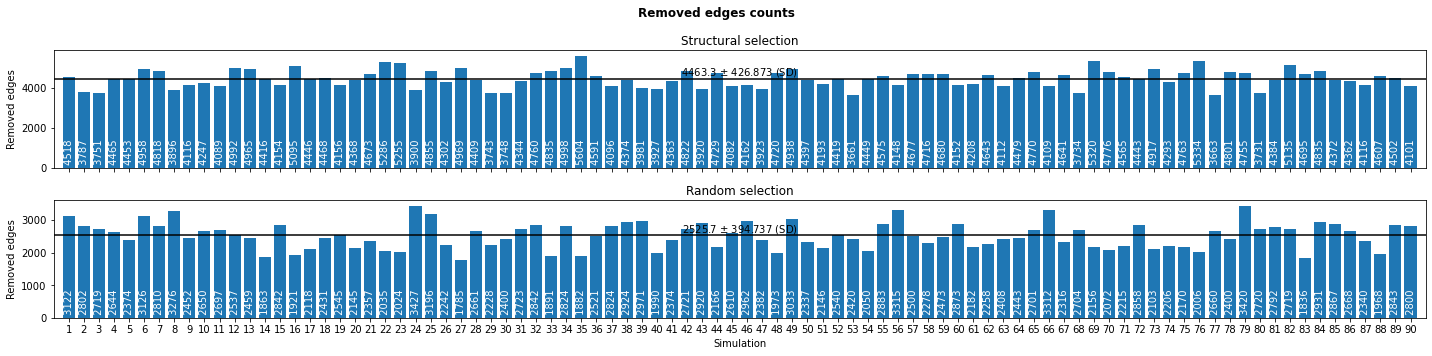

In [94]:
# Extract counts of disconnected edges
num_del_edges_struct = np.array(res_struct[0])
num_del_edges_rnd = np.array(res_rnd[0])

print(f'(i) Structured selection: Between {np.min(num_del_edges_struct)} and {np.max(num_del_edges_struct)} connections removed; MEAN {np.mean(num_del_edges_struct):.1f} +/- {np.std(num_del_edges_struct):.1f} (SD)')
print(f'[{", ".join(num_del_edges_struct.astype(str))}]')
print(f'(ii) Random selection: Between {np.min(num_del_edges_rnd)} and {np.max(num_del_edges_rnd)} connections removed; MEAN {np.mean(num_del_edges_rnd):.1f} +/- {np.std(num_del_edges_rnd):.1f} (SD)')
print(f'[{", ".join(num_del_edges_rnd.astype(str))}]')

del_edges_file = os.path.join(save_path, f'removed_edges_counts')
with open(del_edges_file + f'_struct_{len(num_del_edges_struct)}sims.txt', 'w') as f:
    f.write(', '.join(num_del_edges_struct.astype(str)))
with open(del_edges_file + f'_rnd_{len(num_del_edges_rnd)}sims.txt', 'w') as f:
    f.write(', '.join(num_del_edges_rnd.astype(str)))

sim_nr = np.arange(1, b + 1)
plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.bar(sim_nr, num_del_edges_struct)
for idx, cnt in enumerate(num_del_edges_struct):
    plt.text(sim_nr[idx], 0, f' {cnt}', color='w', rotation=90, ha='center', va='bottom')
plt.xlim([min(sim_nr) - 1, max(sim_nr) + 1])
plt.hlines(np.mean(num_del_edges_struct), *plt.xlim(), color='k')
plt.text(np.mean(plt.xlim()), np.mean(num_del_edges_struct), f'{np.mean(num_del_edges_struct):.1f} $\pm$ {np.std(num_del_edges_struct):.3f} (SD)', ha='center', va='bottom')
plt.xticks(sim_nr, labels=[])
plt.ylabel('Removed edges')
plt.title('Structural selection')
plt.subplot(2, 1, 2)
plt.bar(sim_nr, num_del_edges_rnd)
for idx, cnt in enumerate(num_del_edges_rnd):
    plt.text(sim_nr[idx], 0, f' {cnt}', color='w', rotation=90, ha='center', va='bottom')
plt.xlim([min(sim_nr) - 1, max(sim_nr) + 1])
plt.hlines(np.mean(num_del_edges_rnd), *plt.xlim(), color='k')
plt.text(np.mean(plt.xlim()), np.mean(num_del_edges_rnd), f'{np.mean(num_del_edges_rnd):.1f} $\pm$ {np.std(num_del_edges_rnd):.3f} (SD)', ha='center', va='bottom')
plt.xticks(sim_nr)
plt.xlabel('Simulation')
plt.ylabel('Removed edges')
plt.title('Random selection')
plt.suptitle('Removed edges counts', fontweight='bold')
plt.tight_layout()
plt.savefig(del_edges_file + '.png', dpi=300)
plt.show()

ℹ️ Using (i) 90 counts from structural selection [4518, ..., 4101] and (ii) 90 counts from random selection [3122, ..., 2800] to set up simulation campaign!

__Check counts of actual simulation campaign__

In [276]:
# Structural selection
sim_path = '/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/bbp_workflow/6852a83f-3e7c-4705-b6cd-fe2a34bbfba2'
conns_file = '/gpfs/bbp.cscs.ch/project/proj102/egas/reliability/data/V5_EXC_rc_pairs_5_and_6_spine.npy'
conns_ref = np.load(conns_file).T.tolist() # Reference list of connections to sample from
print('CHECKING...', end='')
for sidx, num in enumerate(num_del_edges_struct):
    print(f'{sidx} ', end='')
    c = Circuit(os.path.join(sim_path, str(sidx), 'BlueConfig'))
    assert len(list(filter(lambda t: 'ConnRemoved' in t, c.cells.targets))) == 2 * num, 'ERROR: Wrong number of connection blocks!'
    conns_list = []
    for n in range(num):
        src = c.cells.ids(f'ConnRemoved_{n}_src')
        dest = c.cells.ids(f'ConnRemoved_{n}_dest')
        assert len(src) == len(dest) == 1, f'ERROR: Multiple Source/target GIDs for connection {n} found!'
        conns_list.append([src[0], dest[0]])
    conns_list = np.unique(conns_list, axis=0).tolist()
    assert len(conns_list) == num, 'ERROR: Wrong number of connection to be removed!'
    conns_in_ref1 = np.array([conns_list[i] in conns_ref for i in range(len(conns_list))]) # One direction
    conns_in_ref2 = np.array([conns_list[i][::-1] in conns_ref for i in range(len(conns_list))]) # Other direction
    assert np.all(conns_in_ref1.astype(int) + conns_in_ref2.astype(int) == 1), 'ERROR: Connection not in referene list (either direction)!'
print('OK')

CHECKING...0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 OK


In [293]:
# Random selection
sim_path = '/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/bbp_workflow/1477add6-7a81-445b-a43a-e03dd27bf9e2'
conns_file = '/gpfs/bbp.cscs.ch/project/proj102/egas/reliability/data/V5_EXC_rc_pairs_all.npy'
conns_ref = np.load(conns_file).T.tolist() # Reference list of connections to sample from
print('CHECKING...', end='')
for sidx, num in enumerate(num_del_edges_rnd):
    print(f'{sidx} ', end='')
    c = Circuit(os.path.join(sim_path, str(sidx), 'BlueConfig'))
    assert len(list(filter(lambda t: 'ConnRemoved' in t, c.cells.targets))) == 2 * num, 'ERROR: Wrong number of connection blocks!'
    conns_list = []
    for n in range(num):
        src = c.cells.ids(f'ConnRemoved_{n}_src')
        dest = c.cells.ids(f'ConnRemoved_{n}_dest')
        assert len(src) == len(dest) == 1, f'ERROR: Multiple Source/target GIDs for connection {n} found!'
        conns_list.append([src[0], dest[0]])
    conns_list = np.unique(conns_list, axis=0).tolist()
    assert len(conns_list) == num, 'ERROR: Wrong number of connection to be removed!'
    conns_in_ref1 = np.array([conns_list[i] in conns_ref for i in range(len(conns_list))]) # One direction
    conns_in_ref2 = np.array([conns_list[i][::-1] in conns_ref for i in range(len(conns_list))]) # Other direction
    assert np.all(conns_in_ref1.astype(int) + conns_in_ref2.astype(int) == 1), 'ERROR: Connection not in referene list (either direction)!'
print('OK')

CHECKING...0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 OK


In [17]:
# Plot distributions
def plot_distributions(res, n_bins=20, name='Sim'):
    num_del_edges, indeg_orig_all, indeg_manip_all, indeg_orig_within, indeg_manip_within, indeg_orig_outside, indeg_manip_outside = res

    mn_col = 'k'
    plt.figure(figsize=(5, 3))
    rng = np.max(num_del_edges) - np.min(num_del_edges)
    plt.hist(num_del_edges, bins=n_bins if rng > 0 else np.linspace(np.mean(num_del_edges) - 3 * rng, np.mean(num_del_edges) + 3 * rng, n_bins + 1))
    plt.vlines(np.mean(num_del_edges), ymin=min(plt.ylim()), ymax=max(plt.ylim()), color=mn_col)
    plt.text(np.mean(num_del_edges), np.mean(plt.ylim()), f'{np.mean(num_del_edges):.3f} $\pm$ {np.std(num_del_edges):.3f} (SD)', rotation=90, ha='right', va='center', color=mn_col)
    plt.xlabel('Number of deleted edges')
    plt.ylabel(f'{name} count')
    plt.title('Deleted edges', fontweight='bold')
    plt.show()

    plt.figure(figsize=(15, 3))
    plt.subplot(1, 3, 1)
    rng = np.max(indeg_orig_all) - np.min(indeg_orig_all)
    plt.hist(indeg_orig_all, bins=n_bins if rng > 0 else np.linspace(np.mean(indeg_orig_all) - 3 * rng, np.mean(indeg_orig_all) + 3 * rng, n_bins + 1))
    plt.vlines(np.mean(indeg_orig_all), ymin=min(plt.ylim()), ymax=max(plt.ylim()), color=mn_col)
    plt.text(np.mean(indeg_orig_all), np.mean(plt.ylim()), f'{np.mean(indeg_orig_all):.3f} $\pm$ {np.std(indeg_orig_all):.3f} (SD)', rotation=90, ha='right', va='center', color=mn_col)
    plt.xticks(np.unique(indeg_orig_all))
    plt.xlabel('ORIG In-degree (all manip)')
    plt.ylabel(f'{name} count')
    plt.subplot(1, 3, 2)
    rng = np.max(indeg_orig_within) - np.min(indeg_orig_within)
    plt.hist(indeg_orig_within, bins=n_bins if rng > 0 else np.linspace(np.mean(indeg_orig_within) - 3 * rng, np.mean(indeg_orig_within) + 3 * rng, n_bins + 1))
    plt.vlines(np.mean(indeg_orig_within), ymin=min(plt.ylim()), ymax=max(plt.ylim()), color=mn_col)
    plt.text(np.mean(indeg_orig_within), np.mean(plt.ylim()), f'{np.mean(indeg_orig_within):.3f} $\pm$ {np.std(indeg_orig_within):.3f} (SD)', rotation=90, ha='right', va='center', color=mn_col)
    plt.xlabel('ORIG In-degree (within manip)')
    plt.ylabel(f'{name} count')
    plt.subplot(1, 3, 3)
    rng = np.max(indeg_orig_outside) - np.min(indeg_orig_outside)
    plt.hist(indeg_orig_outside, bins=n_bins if rng > 0 else np.linspace(np.mean(indeg_orig_outside) - 3 * rng, np.mean(indeg_orig_outside) + 3 * rng, n_bins + 1))
    plt.vlines(np.mean(indeg_orig_outside), ymin=min(plt.ylim()), ymax=max(plt.ylim()), color=mn_col)
    plt.text(np.mean(indeg_orig_outside), np.mean(plt.ylim()), f'{np.mean(indeg_orig_outside):.3f} $\pm$ {np.std(indeg_orig_outside):.3f} (SD)', rotation=90, ha='right', va='center', color=mn_col)
    plt.xlabel('ORIG In-degree (outside manip)')
    plt.ylabel(f'{name} count')
    plt.suptitle('ORIG In-degrees', fontweight='bold')
    plt.show()

    plt.figure(figsize=(15, 3))
    plt.subplot(1, 3, 1)
    rng = np.max(indeg_manip_all) - np.min(indeg_manip_all)
    plt.hist(indeg_manip_all, bins=n_bins if rng > 0 else np.linspace(np.mean(indeg_manip_all) - 3 * rng, np.mean(indeg_manip_all) + 3 * rng, n_bins + 1))
    plt.vlines(np.mean(indeg_manip_all), ymin=min(plt.ylim()), ymax=max(plt.ylim()), color=mn_col)
    plt.text(np.mean(indeg_manip_all), np.mean(plt.ylim()), f'{np.mean(indeg_manip_all):.3f} $\pm$ {np.std(indeg_manip_all):.3f} (SD)', rotation=90, ha='right', va='center', color=mn_col)
    plt.xlabel('MANIP In-degree (all manip)')
    plt.ylabel(f'{name} count')
    plt.subplot(1, 3, 2)
    rng = np.max(indeg_manip_within) - np.min(indeg_manip_within)
    plt.hist(indeg_manip_within, bins=n_bins if rng > 0 else np.linspace(np.mean(indeg_manip_within) - 3 * rng, np.mean(indeg_manip_within) + 3 * rng, n_bins + 1))
    plt.vlines(np.mean(indeg_manip_within), ymin=min(plt.ylim()), ymax=max(plt.ylim()), color=mn_col)
    plt.text(np.mean(indeg_manip_within), np.mean(plt.ylim()), f'{np.mean(indeg_manip_within):.3f} $\pm$ {np.std(indeg_manip_within):.3f} (SD)', rotation=90, ha='right', va='center', color=mn_col)
    plt.xlabel('MANIP In-degree (within manip)')
    plt.ylabel(f'{name} count')
    plt.subplot(1, 3, 3)
    rng = np.max(indeg_manip_outside) - np.min(indeg_manip_outside)
    plt.hist(indeg_manip_outside, bins=n_bins if rng > 0 else np.linspace(np.mean(indeg_manip_outside) - 3 * rng, np.mean(indeg_manip_outside) + 3 * rng, n_bins + 1))
    plt.vlines(np.mean(indeg_manip_outside), ymin=min(plt.ylim()), ymax=max(plt.ylim()), color=mn_col)
    plt.text(np.mean(indeg_manip_outside), np.mean(plt.ylim()), f'{np.mean(indeg_manip_outside):.3f} $\pm$ {np.std(indeg_manip_outside):.3f} (SD)', rotation=90, ha='right', va='center', color=mn_col)
    plt.xlabel('MANIP In-degree (outside manip)')
    plt.ylabel(f'{name} count')
    plt.suptitle('MANIP In-degrees', fontweight='bold')
    plt.show()

    plt.figure(figsize=(15, 3))
    plt.subplot(1, 3, 1)
    indeg_diff = np.array(indeg_orig_all) - np.array(indeg_manip_all)
    rng = np.max(indeg_diff) - np.min(indeg_diff)
    plt.hist(indeg_diff, bins=n_bins if rng > 0 else np.linspace(np.mean(indeg_diff) - 3 * rng, np.mean(indeg_diff) + 3 * rng, n_bins + 1))
    plt.vlines(np.mean(indeg_diff), ymin=min(plt.ylim()), ymax=max(plt.ylim()), color=mn_col)
    plt.text(np.mean(indeg_diff), np.mean(plt.ylim()), f'{np.mean(indeg_diff):.3f} $\pm$ {np.std(indeg_diff):.3f} (SD)', rotation=90, ha='right', va='center', color=mn_col)
    plt.xlabel('ORIG-MANIP In-degree (all manip)')
    plt.ylabel(f'{name} count')
    plt.subplot(1, 3, 2)
    indeg_diff = np.array(indeg_orig_within) - np.array(indeg_manip_within)
    rng = np.max(indeg_diff) - np.min(indeg_diff)
    plt.hist(indeg_diff, bins=n_bins if rng > 0 else np.linspace(np.mean(indeg_diff) - 3 * rng, np.mean(indeg_diff) + 3 * rng, n_bins + 1))
    plt.vlines(np.mean(indeg_diff), ymin=min(plt.ylim()), ymax=max(plt.ylim()), color=mn_col)
    plt.text(np.mean(indeg_diff), np.mean(plt.ylim()), f'{np.mean(indeg_diff):.3f} $\pm$ {np.std(indeg_diff):.3f} (SD)', rotation=90, ha='right', va='center', color=mn_col)
    plt.xlabel('ORIG-MANIP In-degree (within manip)')
    plt.ylabel(f'{name} count')
    plt.subplot(1, 3, 3)
    indeg_diff = np.array(indeg_orig_outside) - np.array(indeg_manip_outside)
    rng = np.max(indeg_diff) - np.min(indeg_diff)
    plt.hist(indeg_diff, bins=n_bins if rng > 0 else np.linspace(np.mean(indeg_diff) - 3 * rng, np.mean(indeg_diff) + 3 * rng, n_bins + 1))
    plt.vlines(np.mean(indeg_diff), ymin=min(plt.ylim()), ymax=max(plt.ylim()), color=mn_col)
    plt.text(np.mean(indeg_diff), np.mean(plt.ylim()), f'{np.mean(indeg_diff):.3f} $\pm$ {np.std(indeg_diff):.3f} (SD)', rotation=90, ha='right', va='center', color=mn_col)
    plt.xlabel('ORIG-MANIP In-degree (outside manip)')
    plt.ylabel(f'{name} count')
    plt.suptitle('Change in in-degrees (ORIG-MANIP)', fontweight='bold')
    plt.show()

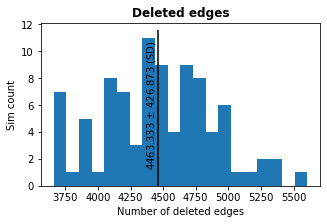

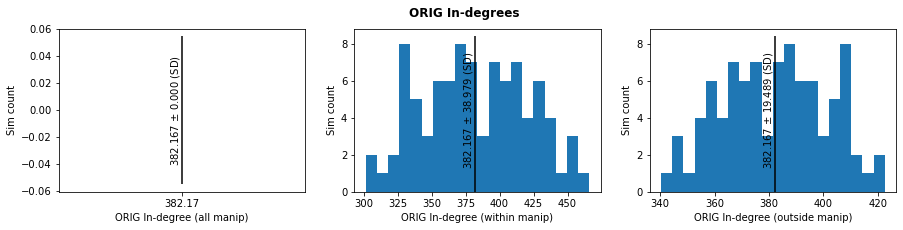

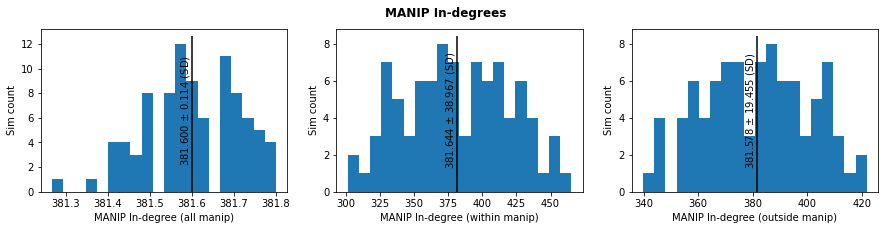

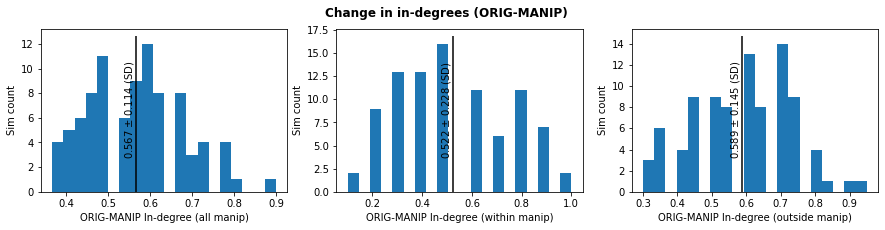

In [18]:
# Structural sampling
plot_distributions(res_struct)

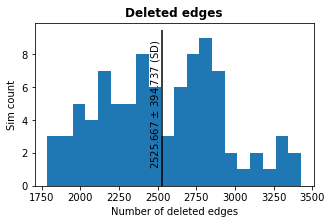

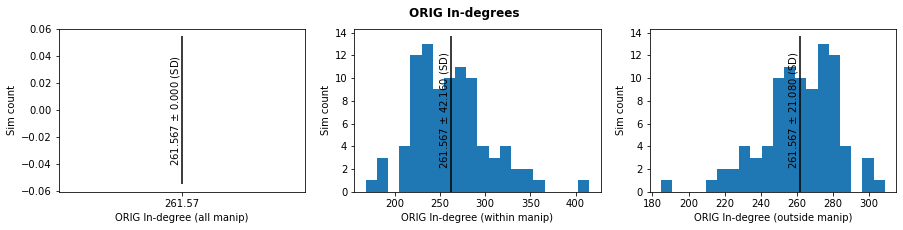

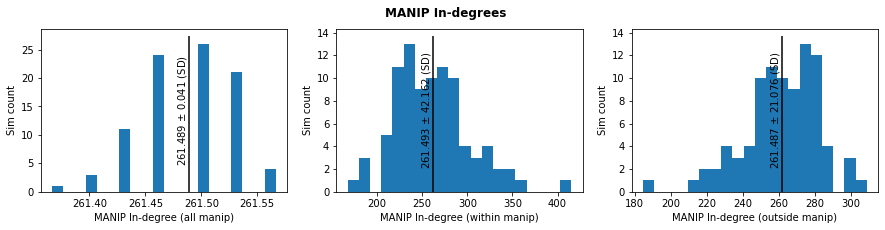

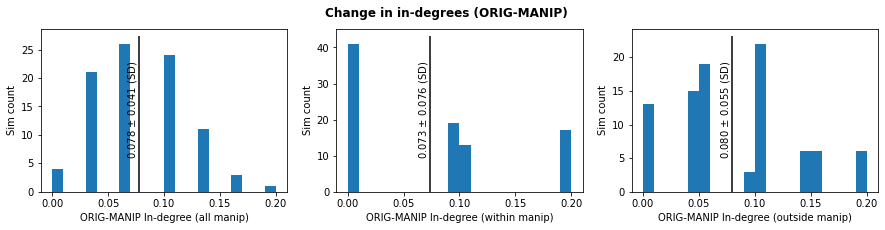

In [19]:
# Random sampling
plot_distributions(res_rnd)

### Evaluate distributions over many randomized block designs for disconnecting outgoing connections

In [14]:
# Compute results tables
num_block_designs = 50
block_seeds = np.arange(num_block_designs)
res_tables_struct = []
res_tables_rnd = []
for bidx in tqdm.tqdm(range(num_block_designs)):
    block_table = generate_random_block_table(r, k, v, b, seed=block_seeds[bidx])
    res_tables_struct.append(evaluate_manip_sim(adj_exc, gids_manip_struct, gid_mapping, block_table, disable_tqdm=True))
    res_tables_rnd.append(evaluate_manip_sim(adj_exc, gids_manip_rnd, gid_mapping, block_table, disable_tqdm=True))

# ...and save results
np.savez('res_tables.npz', res_tables_struct=res_tables_struct, res_tables_rnd=res_tables_rnd, num_block_designs=num_block_designs, block_seeds=block_seeds, gids_manip_struct=gids_manip_struct, gids_manip_rnd=gids_manip_rnd)

  0%|          | 0/50 [00:00<?, ?it/s]/gpfs/bbp.cscs.ch/ssd/apps/bsd/2022-01-10/stage_applications/install_gcc-11.2.0-skylake/py-scipy-1.7.1-2qre6w/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 50/50 [1:39:09<00:00, 118.99s/it]


In [125]:
# OR: Load pre-computed results
# [Results columns: num_del_edges, indeg_orig_all, indeg_manip_all, indeg_orig_within, indeg_manip_within, indeg_orig_outside, indeg_manip_outside]
res_dict = np.load('res_tables.npz')
res_tables_struct = res_dict['res_tables_struct']
res_tables_rnd = res_dict['res_tables_rnd']
num_block_designs = res_dict['num_block_designs']
block_seeds = res_dict['block_seeds']
gids_manip_struct = res_dict['gids_manip_struct']
gids_manip_rnd = res_dict['gids_manip_rnd']

In [148]:
# Look at distributions over random block designs
def plot_histograms(data, data_name, num_bins, new_fig=True):
    bins = np.linspace(np.min(data) - 0.1 * np.mean(data), np.max(data) + 0.1 * np.mean(data), num_bins + 1)
    bin_size = np.mean(np.diff(bins))
    if new_fig:
        plt.figure(figsize=(5, 3))
    for n_block in range(data.shape[0]):
        data_hist, _ = np.histogram(data[n_block, :], bins=bins)
        plt.plot(bins[:-1] + 0.5 * bin_size, data_hist, '-k', alpha=0.1)
    plt.ylim(plt.ylim())
    for n_block in range(data.shape[0]):
        plt.vlines(np.mean(data[n_block, :]), ymin=np.min(plt.ylim()), ymax=np.max(plt.ylim()), color='tab:blue', alpha=0.2, linewidth=1, label='Mean' if n_block==0 else None)
    plt.xlabel(data_name)
    plt.ylabel('Sim count')
    plt.title(f'Histograms of {data.shape[0]} block designs', fontweight='bold' if new_fig else None)
    plt.legend()
    if new_fig:
        plt.tight_layout()
        plt.show()

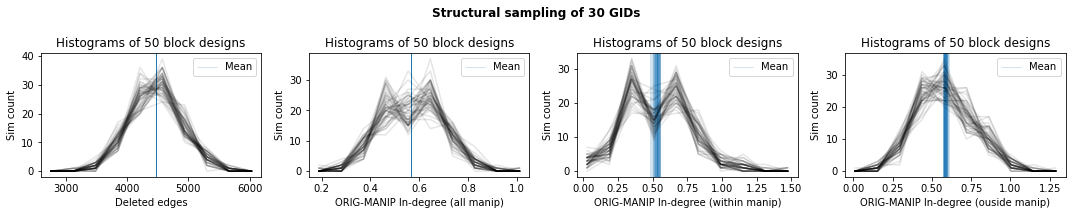

In [161]:
plt.figure(figsize=(15, 3))
plt.subplot(1, 4, 1)
plot_histograms(np.squeeze(res_tables_struct[:, 0, :]), data_name='Deleted edges', num_bins=10, new_fig=False)
plt.subplot(1, 4, 2)
plot_histograms(np.squeeze(res_tables_struct[:, 1, :] - res_tables_struct[:, 2, :]), data_name='ORIG-MANIP In-degree (all manip)', num_bins=10, new_fig=False)
plt.subplot(1, 4, 3)
plot_histograms(np.squeeze(res_tables_struct[:, 3, :] - res_tables_struct[:, 4, :]), data_name='ORIG-MANIP In-degree (within manip)', num_bins=10, new_fig=False)
plt.subplot(1, 4, 4)
plot_histograms(np.squeeze(res_tables_struct[:, 5, :] - res_tables_struct[:, 6, :]), data_name='ORIG-MANIP In-degree (ouside manip)', num_bins=10, new_fig=False)
plt.suptitle(f'Structural sampling of {len(gids_manip_struct)} GIDs', fontweight='bold')
plt.tight_layout()
plt.show()

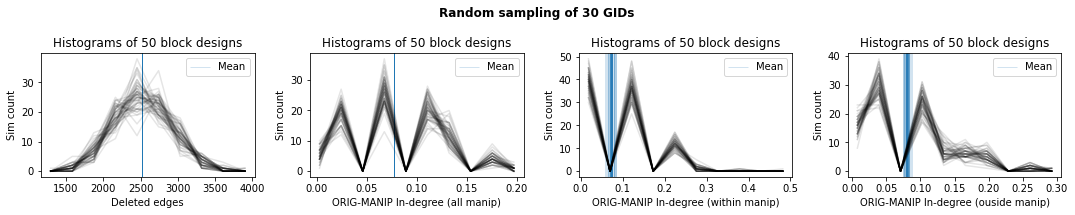

In [159]:
plt.figure(figsize=(15, 3))
plt.subplot(1, 4, 1)
plot_histograms(np.squeeze(res_tables_rnd[:, 0, :]), data_name='Deleted edges', num_bins=10, new_fig=False)
plt.subplot(1, 4, 2)
plot_histograms(np.squeeze(res_tables_rnd[:, 1, :] - res_tables_rnd[:, 2, :]), data_name='ORIG-MANIP In-degree (all manip)', num_bins=10, new_fig=False)
plt.subplot(1, 4, 3)
plot_histograms(np.squeeze(res_tables_rnd[:, 3, :] - res_tables_rnd[:, 4, :]), data_name='ORIG-MANIP In-degree (within manip)', num_bins=10, new_fig=False)
plt.subplot(1, 4, 4)
plot_histograms(np.squeeze(res_tables_rnd[:, 5, :] - res_tables_rnd[:, 6, :]), data_name='ORIG-MANIP In-degree (ouside manip)', num_bins=10, new_fig=False)
plt.suptitle(f'Random sampling of {len(gids_manip_struct)} GIDs', fontweight='bold')
plt.tight_layout()
plt.show()

In [15]:
# # Compute mean over simulations for each block design
# mean_res_table_struct = np.mean(res_tables_struct, 2).T.tolist()
# mean_res_table_rnd = np.mean(res_tables_rnd, 2).T.tolist()

In [ ]:
# plot_distributions(mean_res_table_struct, name='Block design')

In [ ]:
# plot_distributions(mean_res_table_rnd, name='Block design')